# Timeseries

https://carmengg.github.io/eds-220-book/lectures/lesson-7-time-series.html

## How does pandas handle time? 

pandas represents an instant in time using the pandas.Timestamp class. For example:

In [1]:
import pandas as pd

# create a timestamp
pd.Timestamp(year=2020, month=10, day=18, hour=13, minute=1, second=15)

Timestamp('2020-10-18 13:01:15')

When we store multiple Timestamps in a pd.Series (for example when we have a column of dates) the data type of the column is set to datetime64[ns]:

In [2]:
# Notice the dtype of the column is datetime64
pd.Series([pd.Timestamp(2020,10,18), 
           pd.Timestamp(2020,10,19),
           pd.Timestamp(2020,10,20)])

0   2020-10-18
1   2020-10-19
2   2020-10-20
dtype: datetime64[ns]

## Data: Precipitation in Boulder, CO

To exemplify some of the basic time series functionalities we’ll be using data about hourly precipitation in the county of Boulder, Colorado from 2000 to 2014. In September 2013, an unusual weather pattern led to some of the most intense precipitation ever recorded in this region, causing devastating floods throughout the Colorado Front Range. Our goal is to visualize precipitation data in 2013 and identify this unusual weather event.

This data was obtained via the National Oceanic and Atmosperic Administration (NOAA) Climate Data Online service. This dataset is a csv and can be acceses at this link. You can view the full documentation here. The following is a summary of the column descriptions:

- STATION: identification number indentifying the station.
- STATION_NAME: optional field, name identifying the station location.
- DATE: this is the year of the record (4 digits), followed by month (2 digits), followed by day of the month (2 digits), followed by a space and ending with a time of observation that is a two digit indication of the local time hour, followed by a colon (:) followed by a two digit indication of the minute which for this dataset will always be 00. Note: The subsequent data value will be for the hour ending at the time specified here. Hour 00:00 will be listed as the first hour of each date, however since this data is by definition an accumulation of the previous 60 minutes, it actually occurred on the previous day.
- HPCP: The amount of precipitation recorded at the station for the hour ending at the time specified for DATE above given in inches. The values 999.99 means the data value is missing. Hours with no precipitation are not shown.

links: 
- Data: https://www.ncei.noaa.gov/orders/cdo/3488381.csv
- Documentation: https://www.ncei.noaa.gov/pub/data/cdo/documentation/PRECIP_HLY_documentation.pdf


## Data preparation

Let’s start by reading in the data and taking a look at it.

In [3]:
# read in data 
url = 'https://raw.githubusercontent.com/carmengg/eds-220-book/main/data/boulder_colorado_2013_hourly_precipitation.csv'
precip = pd.read_csv(url)

# check df's head
precip.head()

,STATION,STATION_NAME,DATE,HPCP,Measurement Flag,Quality Flag
0,COOP:055881,NEDERLAND 5 NNW CO US,20000101 00:00,999.99,],
1,COOP:055881,NEDERLAND 5 NNW CO US,20000101 01:00,0.00,g,
2,COOP:055881,NEDERLAND 5 NNW CO US,20000102 20:00,0.00,,q
3,COOP:055881,NEDERLAND 5 NNW CO US,20000103 01:00,0.00,,q
4,COOP:055881,NEDERLAND 5 NNW CO US,20000103 05:00,0.00,,q


<AxesSubplot:>

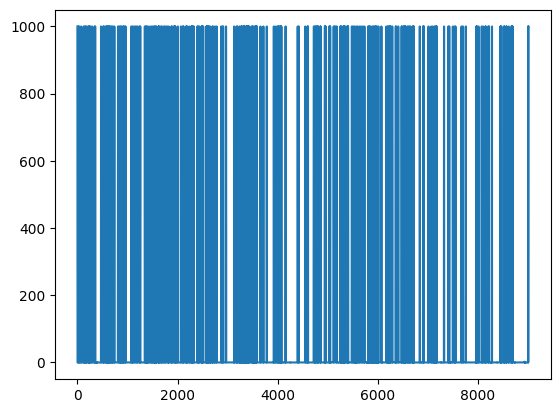

In [4]:
# Let’s make a first attempt at plotting the precipitation:
# column wanted: HPCP
precip.HPCP.plot() #gross

There’s a few things going on with this graph:

1. There are many jumps close to 1000. This is clearly not right and these are outliers. Looking at the column description we can see 999.99 indicates the HPCP data is missing. (We know this from the documentation!)

2. The x-axis values are given by the index of the dataframe and not relative to time.

3. We are only intersted in the precipitation data from 2013, this graph is trying to plot all our data.

4. Let’s fix each one of these issues separately.


## Missing Data

The metadata states the missing values are indicated by the number 999.99. We can use this information to reload the dataframe indicating 999.99 is the missing value. 

How: we add the na_values parameter to the pd.read_csv() function to indicitate additional values that should be recognized as NA:

In [5]:
# read in csv indicating NA values are the 999.99
# note: the url was saves in a url variable above!
precip = pd.read_csv(url, na_values=[999.99])

# check updated df
precip.head()

,STATION,STATION_NAME,DATE,HPCP,Measurement Flag,Quality Flag
0,COOP:055881,NEDERLAND 5 NNW CO US,20000101 00:00,NaN,],
1,COOP:055881,NEDERLAND 5 NNW CO US,20000101 01:00,0.0,g,
2,COOP:055881,NEDERLAND 5 NNW CO US,20000102 20:00,0.0,,q
3,COOP:055881,NEDERLAND 5 NNW CO US,20000103 01:00,0.0,,q
4,COOP:055881,NEDERLAND 5 NNW CO US,20000103 05:00,0.0,,q


<AxesSubplot:>

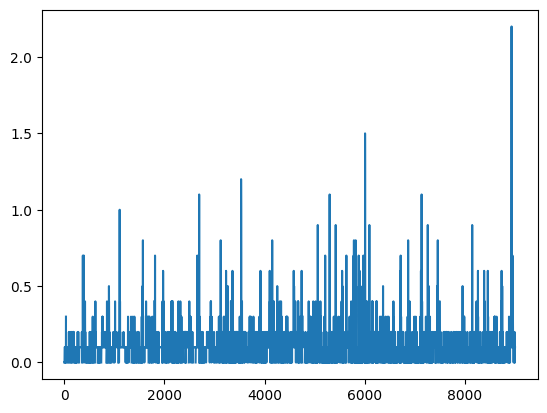

In [6]:
# We can try making our plot again:

precip.HPCP.plot()

# We still need to set the index as the time

## Strings into dates

Notice that the DATE column in our dataframe is not of type datetime. We can check this using the dtypes attribute for dataframes.

The object dtype means that (most likely) all values in that column are strings. **We can convert strings to datetime objects using the `to_datetime()` pandas function**:

- pd.to_datetime() input: a pd.Series with strings that can be converted to dates
- pd.to_datetime() output: a pd.Series with the strings converted to datetime objects


In [7]:
# check the dtypes of all columns
precip.dtypes

STATION              object
STATION_NAME         object
DATE                 object
HPCP                float64
Measurement Flag     object
Quality Flag         object
dtype: object

In [8]:
# covert precip.DATE column to timedate objects
pd.to_datetime(precip.DATE)

0      2000-01-01 00:00:00
1      2000-01-01 01:00:00
2      2000-01-02 20:00:00
3      2000-01-03 01:00:00
4      2000-01-03 05:00:00
               ...        
9001   2013-12-22 01:00:00
9002   2013-12-23 00:00:00
9003   2013-12-23 02:00:00
9004   2013-12-29 01:00:00
9005   2013-12-31 00:00:00
Name: DATE, Length: 9006, dtype: datetime64[ns]

We can overwrite the DATE column with this output:


In [9]:
# convert DATE column from string to timestamps
precip.DATE = pd.to_datetime(precip.DATE)

# check column data type is updated
print(precip.dtypes)

# check new values
precip.head(2)

STATION                     object
STATION_NAME                object
DATE                datetime64[ns]
HPCP                       float64
Measurement Flag            object
Quality Flag                object
dtype: object


,STATION,STATION_NAME,DATE,HPCP,Measurement Flag,Quality Flag
0,COOP:055881,NEDERLAND 5 NNW CO US,2000-01-01 00:00:00,NaN,],
1,COOP:055881,NEDERLAND 5 NNW CO US,2000-01-01 01:00:00,0.0,g,


In [10]:
# Now each value in the date column is a timestamp

type(precip.DATE.iloc[0])

pandas._libs.tslibs.timestamps.Timestamp

<AxesSubplot:xlabel='DATE'>

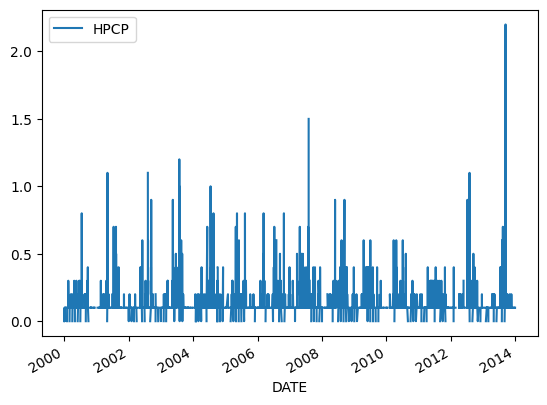

In [11]:
# And we can make another try at plotting our precipitation data:

precip.plot(x='DATE', y='HPCP')

## Timestamp index

At its core, we have time series data if our data frame is indexed by moments in time. Using our DATE column as the index will allows us to do many operations with respect to time, including subsetting and resampling.

***A timeseries is essentially always a dataframe indexed by time***

Updating the index of a dataframe is simple, we use the set_index() method. It’s general syntax is:

```
df = df.set_index(new_index)
```

where new_index is:

- the name of the column (string) we want to set as index, or
- if our new index is not a column in the dataframe, an array or pd.Series of the same length as our data frame (we need one index per row!).

Notice that set_index does not modify the data frame in place.

Example

In our precipitation data this is:


In [12]:
# syntax: df = df.set_index(new_index)

# set DATE coumn as index
precip = precip.set_index('DATE')

# check new index
precip.head(2)

,STATION,STATION_NAME,HPCP,Measurement Flag,Quality Flag
DATE,,,,,
2000-01-01 00:00:00,COOP:055881,NEDERLAND 5 NNW CO US,NaN,],
2000-01-01 01:00:00,COOP:055881,NEDERLAND 5 NNW CO US,0.0,g,


<AxesSubplot:xlabel='DATE'>

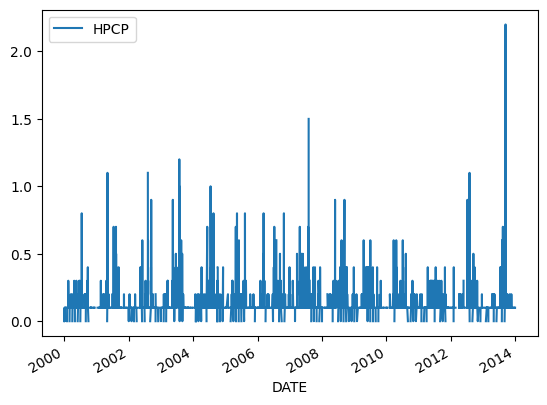

In [13]:
# simplify our plotting bc the default is to plot the INDEX!
precip.plot()

## Subsetting by date

pandas has great functionality to subset a dataframe when using a time index. These are some examples:

In [14]:
# select data from a given month and year
# use loc['year-month']
precip.loc['2013-09']

,STATION,STATION_NAME,HPCP,Measurement Flag,Quality Flag
DATE,,,,,
2013-09-01 00:00:00,COOP:055881,NEDERLAND 5 NNW CO US,NaN,],
2013-09-01 01:00:00,COOP:055881,NEDERLAND 5 NNW CO US,NaN,[,
2013-09-01 00:00:00,COOP:050183,ALLENSPARK 2 SE CO US,NaN,],
2013-09-01 01:00:00,COOP:050183,ALLENSPARK 2 SE CO US,NaN,[,
2013-09-01 00:00:00,COOP:055121,LONGMONT 6 NW CO US,NaN,},
...,...,...,...,...,...
2013-09-23 02:00:00,COOP:050843,BOULDER 2 CO US,0.2,,
2013-09-27 10:00:00,COOP:050843,BOULDER 2 CO US,0.1,,
2013-09-27 15:00:00,COOP:050843,BOULDER 2 CO US,0.1,,


In [15]:
# select data from a given year
# use loc['year']
precip.loc['2013']

,STATION,STATION_NAME,HPCP,Measurement Flag,Quality Flag
DATE,,,,,
2013-01-01 01:00:00,COOP:055881,NEDERLAND 5 NNW CO US,0.0,g,
2013-01-10 02:00:00,COOP:055881,NEDERLAND 5 NNW CO US,NaN,[,
2013-01-13 00:00:00,COOP:055881,NEDERLAND 5 NNW CO US,NaN,],
2013-01-26 20:00:00,COOP:055881,NEDERLAND 5 NNW CO US,0.1,,
2013-01-28 23:00:00,COOP:055881,NEDERLAND 5 NNW CO US,0.1,,
...,...,...,...,...,...
2013-12-22 01:00:00,COOP:050843,BOULDER 2 CO US,NaN,[,
2013-12-23 00:00:00,COOP:050843,BOULDER 2 CO US,NaN,],
2013-12-23 02:00:00,COOP:050843,BOULDER 2 CO US,0.1,,


<AxesSubplot:xlabel='DATE'>

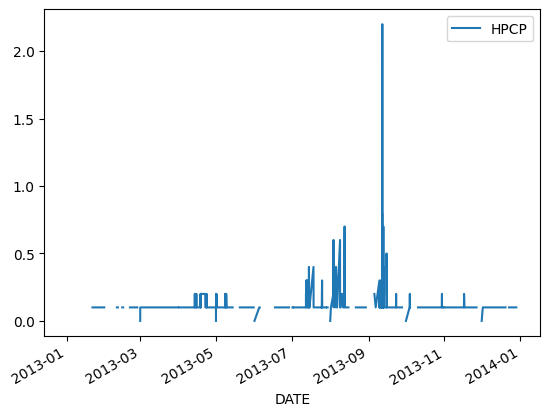

In [16]:
# let's graph our subset of only 2013
precip.loc['2013'].plot()

## Resample

Resampling a time series means converting a time series from one frequency to another. For example, monthly to yearly (downsampling) or weekly to daily (upsampling). We can resample with the resample() method. The simplest use is to call

```
df.resample(new_frequency).aggregator_function()
```

where: 
- new_frequency is a string representing the new frequence to resample the data, for example 'D' for day, w for week, M for month, Y for year, and 
- aggregator_function() is the function we will use to aggregate the data into the new frequence. For example, max(), min(), sum() or average().

resample() works similarly to groupby() in the sense that you need to specify a way to aggregate the data to get any output.

Example

Our 2013 precipitation data has hourly frequency and we want to resample it to daily frequency.

In [17]:
# resample 2013 hourly data to daily frequency
# nothing happens
precip.loc['2013'].resample('D')

To get an output we need to add an aggregator function that indicates how we want to summarize the data that falls on each day. In this case we want the total precipitation on a day, so we will aggreagte using sum():

*Note: resample is very similar to groupby! First groups your data then specify a way to aggregate it*

In [18]:
# total daily precipitation in 2013
# df.resample(new_frequency).aggregator_function()

daily_precip_2013 = precip.loc['2013'].resample('D').sum()

daily_precip_2013

,HPCP
DATE,
2013-01-01,0.0
2013-01-02,0.0
2013-01-03,0.0
2013-01-04,0.0
2013-01-05,0.0
...,...
2013-12-27,0.0
2013-12-28,0.1
2013-12-29,0.0


Notice the index now is every day in 2013. We should rename that column since it is not longer hourly precipitation:

<AxesSubplot:title={'center':'Precipitation in Boulder, CO during 2013'}, xlabel='date', ylabel='daily precipitation (in)'>

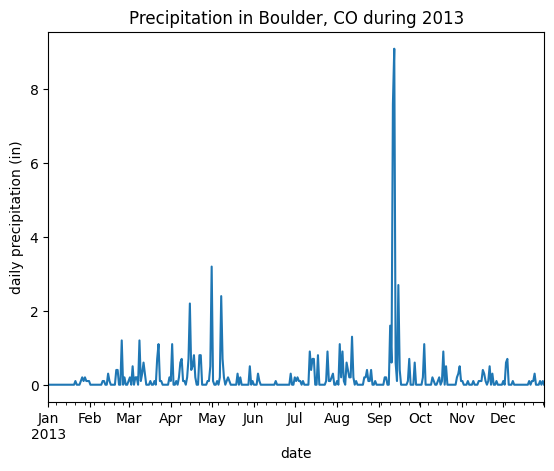

In [19]:
# rename column
daily_precip_2013 = daily_precip_2013.rename(columns={'HPCP':'daily_precipitation'})

# Finally, we can plot our data:

daily_precip_2013.plot(ylabel='daily precipitation (in)', 
                       xlabel='date',
                       title='Precipitation in Boulder, CO during 2013',
                       legend=False)